In [1]:
import os
import re
import numpy as np
import pandas as pd
import librosa as lr
import soundfile as sf

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import librosa

from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


## Data Loading

In [2]:
drive.mount('/content/gdrive')

data_path = 'gdrive/My Drive/api-data/F'

Mounted at /content/gdrive


In [3]:
#select nonwords files

def check_nonwords(file_path):

    '''
    Check if a file is a nonwords file.
    We identify the nonwords files by checking its corresponding transcription file (in the prompts folder).
    The transcription of nonwords files should contain the phrase "[say Ah-P-Eee repeatedly]".
    '''

    # Define a regex pattern to match the phrase "[say Ah-P-Eee repeatedly]"
    pattern = r"\[\s?say\s(?:'?[A-Za-z ]*[A-Za-z]-[A-Za-z\- ]*'?)\s?[^\]]+\]"

    try:
        with open(file_path, 'r') as file:
            content = file.read()
            if re.search(pattern, content):  # Check if pattern matches
                return True
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
    return False


def find_nonwords(folder_path):
    """
    Find all nonwords .txt files in the prompt file that fits the targeting criteria.
    """
    nonwords_files = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(folder_path, file_name)
            if check_nonwords(file_path):   # Check if the file is a nonwords file, if so, add it to the list
                file_name = file_name.split('.')[0]  #extract the file name without the extension
                nonwords_files.append(file_name)

    return nonwords_files


In [4]:
# read the audio files for each participant

def store_file_paths(directory): #the directory here is the participant folder
    """
    The dataset structure is as follows:
    - Each participant has a folder named with the participant's ID, e.g., F01
    - Each participant folder contains multiple session folders, e.g., Session1, Session2, ...
    - Each session folder contains a prompts folder with the transcription files and a wav_headMic folder with the audio files

    - The audio files are named with the format: [file_name].wav
    - The transcription files are named with the format: [file_name].txt

    This function reads the audio files for each participant and returns a list of audio data.
    """
    # find session folders
    session_folders = [folder for folder in os.listdir(directory) if folder.startswith('Session')]
    print(f"Found {len(session_folders)} session folders in participant {directory}")
    # locate the wav_headMic folder and read the audio files
    paths = []
    for session_folder in session_folders:
        nonwords_files = find_nonwords(os.path.join(directory, session_folder, 'prompts'))   # select the nonwords files
        print(f"Found {len(nonwords_files)} nonwords files in session {session_folder}")

        audio_folder_head = os.path.join(directory, session_folder, 'wav_headMic')   # locate the audio folder
        audio_folder_array = os.path.join(directory, session_folder, 'wav_arrayMic')   # locate the audio folder

        #first use the headmic folder to read the audio files, if not found, use the arraymic folder
        if os.path.exists(audio_folder_head):
            audio_folder = audio_folder_head
        else:
            audio_folder = audio_folder_array

        # read the audio files
        for file_name in os.listdir(audio_folder):

            if file_name.split('.')[0] not in nonwords_files:  # check if the file is in the prompt_files, if not, continue
                file_path = os.path.join(audio_folder, file_name)     # read the audio file
                paths.append(file_path)
    return paths

In [5]:
# Function to create a DataFrame of participants and file paths
def participant_files(directory):
    data = []  # List to store participant and file path information

    for participant in os.listdir(directory):
        participant_folder = os.path.join(directory, participant)
        if os.path.isdir(participant_folder):
            file_paths = store_file_paths(participant_folder)

            # Append each file path along with the participant name
            for path in file_paths:
                data.append({'Participant': participant, 'Path': path})

    # Convert the list to a DataFrame
    df = pd.DataFrame(data)
    return df

In [6]:
directory_F = r'gdrive/My Drive/api-data/F'
directory_M = r'gdrive/My Drive/api-data/M'
directory_FC = r'gdrive/My Drive/api-data/FC'
directory_MC = r'gdrive/My Drive/api-data/MC'

In [7]:
data_F = participant_files(directory_F)
data_M = participant_files(directory_M)
data_MC = participant_files(directory_MC)
data_FC = participant_files(directory_FC)

Found 2 session folders in participant gdrive/My Drive/api-data/F/F04
Found 3 nonwords files in session Session1
Found 0 nonwords files in session Session2
Found 1 session folders in participant gdrive/My Drive/api-data/F/F01
Found 4 nonwords files in session Session1
Found 3 session folders in participant gdrive/My Drive/api-data/F/F03
Found 3 nonwords files in session Session1
Found 0 nonwords files in session Session2
Found 0 nonwords files in session Session3
Found 2 session folders in participant gdrive/My Drive/api-data/M/M02
Found 3 nonwords files in session Session1
Found 0 nonwords files in session Session2
Found 2 session folders in participant gdrive/My Drive/api-data/M/M04
Found 3 nonwords files in session Session2
Found 3 nonwords files in session Session1
Found 2 session folders in participant gdrive/My Drive/api-data/M/M05
Found 0 nonwords files in session Session2
Found 3 nonwords files in session Session1
Found 2 session folders in participant gdrive/My Drive/api-data/

In [8]:
# Concatenate the DataFrames
with_dysarthria = pd.concat([data_F, data_M], ignore_index=True)
# Add a new column and assign 1 to all rows
with_dysarthria['Dysarthria'] = 1

# Concatenate the DataFrames
without_dysarthria = pd.concat([data_FC, data_MC], ignore_index=True)
# Add a new column and assign 0 to all rows
without_dysarthria['Dysarthria'] = 0

In [9]:
# Concatenate the DataFrames
data = pd.concat([with_dysarthria, without_dysarthria], ignore_index=True)

# Remove the two rows where we can't read the files
data = data[~data['Path'].isin(['gdrive/My Drive/api-data/F/F01/Session1/wav_headMic/0068.wav',
                          'gdrive/My Drive/api-data/F/F01/Session1/wav_headMic/0067.wav'])]

## Data Splitting

In [10]:
# Create a DataFrame with metadata
data_to_split = [
    {'Participant': 'F01', 'Dysarthria': 1, 'Gender': 'Female'},
    {'Participant': 'F03', 'Dysarthria': 1, 'Gender': 'Female'},
    {'Participant': 'F04', 'Dysarthria': 1, 'Gender': 'Female'},
    {'Participant': 'M01', 'Dysarthria': 1, 'Gender': 'Male'},
    {'Participant': 'M02', 'Dysarthria': 1, 'Gender': 'Male'},
    {'Participant': 'M03', 'Dysarthria': 1, 'Gender': 'Male'},
    {'Participant': 'M04', 'Dysarthria': 1, 'Gender': 'Male'},
    {'Participant': 'M05', 'Dysarthria': 1, 'Gender': 'Male'},
    {'Participant': 'MC01', 'Dysarthria': 0, 'Gender': 'Male'},
    {'Participant': 'MC02', 'Dysarthria': 0, 'Gender': 'Male'},
    {'Participant': 'MC03', 'Dysarthria': 0, 'Gender': 'Male'},
    {'Participant': 'MC04', 'Dysarthria': 0, 'Gender': 'Male'},
    {'Participant': 'FC01', 'Dysarthria': 0, 'Gender': 'Female'},
    {'Participant': 'FC02', 'Dysarthria': 0, 'Gender': 'Female'},
    {'Participant': 'FC03', 'Dysarthria': 0, 'Gender': 'Female'}

]
df = pd.DataFrame(data_to_split)

# Set random seed for reproducibility
random_seed = 42

# Function to randomly sample participants
def sample_participants(df, n_dysarthric, n_non_dysarthric, random_seed=None):
    # Split into dysarthric and non-dysarthric groups
    dysarthric = df[df['Dysarthria'] == 1]
    non_dysarthric = df[df['Dysarthria'] == 0]

    # Randomly sample from each group
    sampled_dysarthric = dysarthric.sample(n=n_dysarthric, random_state=random_seed)
    sampled_non_dysarthric = non_dysarthric.sample(n=n_non_dysarthric, random_state=random_seed)

    # Combine the sampled data
    sampled = pd.concat([sampled_dysarthric, sampled_non_dysarthric])
    return sampled

# Training set: 6 dysarthric (2 women, 4 men) + 5 non-dysarthric (2 women, 3 men)
train = pd.concat([
    sample_participants(df[df['Gender'] == 'Female'], n_dysarthric=2, n_non_dysarthric=2, random_seed=random_seed),
    sample_participants(df[df['Gender'] == 'Male'], n_dysarthric=4, n_non_dysarthric=3, random_seed=random_seed)
])

# Testing set: 2 dysarthric (1 woman, 1 man) + 2 non-dysarthric (1 woman, 1 man)
test = pd.concat([
    sample_participants(
        df[(df['Gender'] == 'Female') & (~df['Participant'].isin(train['Participant']))],
        n_dysarthric=1, n_non_dysarthric=1, random_seed=random_seed
    ),
    sample_participants(
        df[(df['Gender'] == 'Male') & (~df['Participant'].isin(train['Participant']))],
        n_dysarthric=1, n_non_dysarthric=1, random_seed=random_seed
    )
])

# Shuffle the final sets for randomness
train = shuffle(train, random_state=random_seed).reset_index(drop=True)
test = shuffle(test, random_state=random_seed).reset_index(drop=True)

# Print results
print("Training Set:")
print(train)

print("\nTesting Set:")
print(test)

# Verify the distribution
print("\nTraining Dysarthria Distribution:")
print(train['Dysarthria'].value_counts())
print("\nTraining Gender Distribution:")
print(train['Gender'].value_counts())

print("\nTesting Dysarthria Distribution:")
print(test['Dysarthria'].value_counts())
print("\nTesting Gender Distribution:")
print(test['Gender'].value_counts())

Training Set:
   Participant  Dysarthria  Gender
0          M05           1    Male
1          F01           1  Female
2         MC04           0    Male
3         MC01           0    Male
4         FC01           0  Female
5          F03           1  Female
6         MC02           0    Male
7          M02           1    Male
8          M01           1    Male
9         FC02           0  Female
10         M03           1    Male

Testing Set:
  Participant  Dysarthria  Gender
0        FC03           0  Female
1        MC03           0    Male
2         F04           1  Female
3         M04           1    Male

Training Dysarthria Distribution:
Dysarthria
1    6
0    5
Name: count, dtype: int64

Training Gender Distribution:
Gender
Male      7
Female    4
Name: count, dtype: int64

Testing Dysarthria Distribution:
Dysarthria
0    2
1    2
Name: count, dtype: int64

Testing Gender Distribution:
Gender
Female    2
Male      2
Name: count, dtype: int64


In [11]:
# Filter train_df and test_df based on participants in train and test
train_df = data[data['Participant'].isin(train['Participant'])]
test_df = data[data['Participant'].isin(test['Participant'])]

# Reset indices for cleanliness
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Print results
print("Train DataFrame:")
print(train_df)

print("\nTest DataFrame:")
print(test_df)

# Check counts for verification
print("\nTrain Participant Count:")
print(train_df['Participant'].nunique())
print("\nTest Participant Count:")
print(test_df['Participant'].nunique())

Train DataFrame:
     Participant                                               Path  \
0            F01  gdrive/My Drive/api-data/F/F01/Session1/wav_he...   
1            F01  gdrive/My Drive/api-data/F/F01/Session1/wav_he...   
2            F01  gdrive/My Drive/api-data/F/F01/Session1/wav_he...   
3            F01  gdrive/My Drive/api-data/F/F01/Session1/wav_he...   
4            F01  gdrive/My Drive/api-data/F/F01/Session1/wav_he...   
...          ...                                                ...   
6440        MC01  gdrive/My Drive/api-data/MC/MC01/Session1/wav_...   
6441        MC01  gdrive/My Drive/api-data/MC/MC01/Session1/wav_...   
6442        MC01  gdrive/My Drive/api-data/MC/MC01/Session1/wav_...   
6443        MC01  gdrive/My Drive/api-data/MC/MC01/Session1/wav_...   
6444        MC01  gdrive/My Drive/api-data/MC/MC01/Session1/wav_...   

      Dysarthria  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...

In [ ]:
train_df.head()

,Participant,Path,Dysarthria
0,F01,gdrive/My Drive/api-data/F/F01/Session1/wav_he...,1
1,F01,gdrive/My Drive/api-data/F/F01/Session1/wav_he...,1
2,F01,gdrive/My Drive/api-data/F/F01/Session1/wav_he...,1
3,F01,gdrive/My Drive/api-data/F/F01/Session1/wav_he...,1
4,F01,gdrive/My Drive/api-data/F/F01/Session1/wav_he...,1


In [14]:
import librosa
import numpy as np

# Function to extract MFCC, Pitch, Jitter, Shimmer, and Formants
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)  # Load audio with original sampling rate

    # 1. Extract MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)  # Take mean of each MFCC coefficient

    # 2. Extract Pitch (using librosa's piptrack)
    pitch, mag = librosa.core.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitch, axis=1)  # Take mean of pitch values

    # 3. Extract Jitter (frequency variation)
    #jitter = librosa.effects.jitter(y)

    # 4. Extract Shimmer (amplitude variation)
    #shimmer = librosa.effects.shimmer(y)

    # 6. Combine Features
    features = np.concatenate((mfcc_mean, pitch_mean), axis=0)

    return features


In [16]:
import numpy as np
import concurrent.futures

# Function to extract features for a single row (audio file)
def extract_feature_for_row(row):
    audio_path = row['Path']
    label = row['Dysarthria']  # 0 or 1
    features = extract_features(audio_path)  # Extract features
    return features, label

# List to store feature vectors and labels
features_list_train = []
labels_train = []

# Using concurrent.futures to parallelize the extraction process
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Iterate through the dataframe and submit tasks for parallel execution
    results = executor.map(extract_feature_for_row, [row for _, row in train_df.iterrows()])

    # Collect results
    for features, label in results:
        features_list_train.append(features)
        labels_train.append(label)

# Convert lists to numpy arrays for later use
X_train = np.array(features_list_train)
y_train = np.array(labels_train)

print(X_train.shape)  # Check the shape of the feature matrix
print(y_train.shape)  # Check the shape of the labels array


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=955
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=421
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=155
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=151
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=151
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=686
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: 

(6445, 1038)
(6445,)


In [17]:
# List to store feature vectors and labels
features_list_test = []
labels_test = []

# Using concurrent.futures to parallelize the extraction process
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Iterate through the dataframe and submit tasks for parallel execution
    results = executor.map(extract_feature_for_row, [row for _, row in test_df.iterrows()])

    # Collect results
    for features, label in results:
        features_list_test.append(features)
        labels_test.append(label)

# Convert lists to numpy arrays for later use
X_test = np.array(features_list_test)
y_test = np.array(labels_test)

print(X_test.shape)  # Check the shape of the feature matrix
print(y_test.shape)  # Check the shape of the labels array

(2688, 1038)
(2688,)


In [ ]:
# List to store feature vectors
features_list_test = []
labels_test = []

# Iterate through each row in the dataframe
for index, row in train_df.iterrows():
    audio_path = row['Path']
    label = row['Dysarthria']  # 0 or 1

    # Extract features for the audio file
    features = extract_features(audio_path)

    # Append to features_list and labels
    features_list_test.append(features)
    labels_test.append(label)

# Convert lists to numpy arrays for later use
X_test = np.array(features_list_train)
y_test = np.array(labels_train)

print(X_test.shape)  # Check the shape of the feature matrix
print(y_test.shape)  # Check the shape of the labels array

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.6350446428571429


In [39]:
import shap
# Explain the model's predictions with SHAP
X_combined = np.concatenate((X_train, X_test), axis=0)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_combined)

<Figure size 2000x800 with 0 Axes>

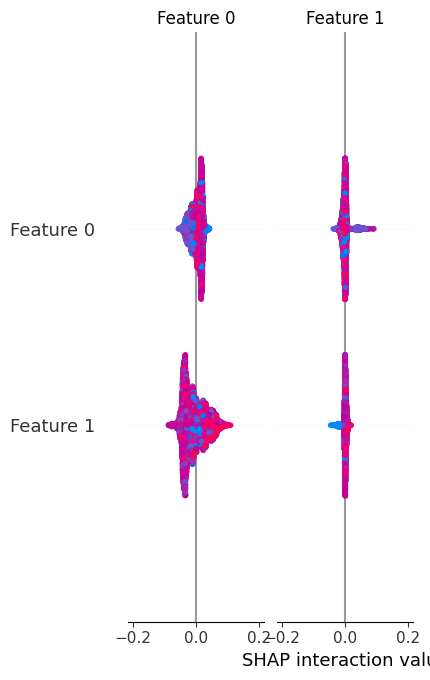

In [42]:
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(20, 8))  # Width=12, Height=8 (adjust as needed)
shap.summary_plot(shap_values, X_combined, plot_type="bar")